## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [23]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import os
from sklearn.metrics import recall_score, accuracy_score, f1_score
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.LeNet = nn.Sequential(     
            # convolutional layers            
            nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
              nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),    # CONVOLUTION 
              nn.BatchNorm2d(6),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2)),                 # POOLING
            nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
              nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),   # CONVOLUTION 
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2)),                 # POOLING
            # fully connected layers
            nn.Flatten(),
            nn.Linear(16 * 125 * 125, 400),                            # THIRD LAYER: LINEAR YEAR, HIDDEN LAYER 2
            nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
            nn.Linear(400, 10)                                        # OUTPUT LAYER
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out



In [49]:
model = CustomNeuralNetwork()

In [6]:
#Dataloader code from Checkpoint #1

resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(512), int(512))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
 
transforms = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.RandomAdjustSharpness(sharpness_factor=10),
            T.ColorJitter(brightness=.5, hue=.3),
            T.Resize((int(512), int(512))),
            # Resize the image to match median ratio using median length 
            T.ToTensor()
        ])
training_data = XRayDataset(train_path, transforms)
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)

#Discussion with Ian said to start with small batches (2,4)
#Medium post said do powers of 2 starting with 16 
#I'll go with middle point and do batch = 8
#https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15

batch_s = 64

train_dataloader = DataLoader(training_data, batch_size=batch_s, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_s, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_s, shuffle=True)


In [7]:
# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() #a.Change the cross entropy of the original code to NLL 
#which we have used before for binary classification
#b. 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
# Think it would be better if we make functions - LS
# 4: Train and validate the network
EPOCHS = 1
train_losses = []
train_accuracies = []
for _ in range(EPOCHS):
    # TRAIN
    model.train()  # Make sure gradient tracking is on, and do a pass over the data
    running_loss = 0.0
    y_true = np.array([])
    y_predict = np.array([])
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights

        # keep track of the loss
        running_loss += loss.item()
        ypred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        ytrue_batch = labels_tensor.numpy()
        y_predict = np.concatenate([y_predict, ypred_batch], axis=0)
        y_true = np.concatenate([y_true, ytrue_batch], axis=0)

    recall = recall_score(y_true, y_predict, average='weighted') # lisette changed average from binary because throwing an error 
    
    # avg_train_acc = total_correct/total_predicted  # calculate average accuracy metric
    avg_train_acc = recall
    avg_train_loss = running_loss / (i + 1)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc) 

In [22]:
print("y_predict", y_predict)
print("y_true", y_true)
print("unique predict", np.unique(y_predict))
print("unique true", np.unique(y_true))

print(train_losses)
print("train acc", train_accuracies)
print("avg train acc", avg_train_acc)
print(avg_train_loss)

y_predict [0. 0. 1. ... 0. 0. 0.]
y_true [0. 0. 1. ... 0. 0. 0.]
unique predict [0. 1.]
unique true [0. 1.]
[0.1059206964039221]
train acc [0.9570552147239264]
avg train acc 0.9570552147239264
0.1059206964039221


In [12]:
print(running_loss)

8.685497105121613


In [18]:
val_losses = []
val_accuracies = []
with torch.no_grad():
    for _ in range(EPOCHS):
        # TEST
        model.eval() # we don't want to keep track of the gradients in the validation part
        running_loss_val = 0.0
        y_true_val = np.array([])
        y_predict_val = np.array([])
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            loss = criterion(outputs, labels_tensor)
            val_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
            total = len(labels)
            correct = (predicted == labels_tensor).sum().item()
            val_accuracies.append(100 * correct / total)
            running_loss_val += loss.item()
            ypred_batch_val = np.argmax(outputs.detach().numpy(), axis=1)
            ytrue_batch_val = labels_tensor.numpy()
            y_predict_val = np.concatenate([y_predict_val, ypred_batch_val], axis=0)
            y_true_val = np.concatenate([y_true_val, ytrue_batch_val], axis=0)

    recall_val = recall_score(y_true_val, y_predict_val, average='binary')
    
    # print(val_accuracies)
    # print(val_losses)
    avg_val_acc = recall_val
    avg_val_loss = running_loss / (i + 1)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(avg_val_acc)
    print(avg_val_loss)
    print(val_accuracies)

0.625
8.685497105121613
[81.25, 0.625]


In [15]:
print(val_accuracies)

[75.0, 0.5]


In [19]:
#5. Test model
EPOCHS = 1
test_losses = []
test_accuracies = []
with torch.no_grad():
    for _ in range(EPOCHS):
        # TEST
        model.train()  # Make sure gradient tracking is on, and do a pass over the data
        running_loss_test = 0.0
        y_true_test = np.array([])
        y_predict_test = np.array([])
        for i, data in enumerate(test_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward pass
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            loss = criterion(outputs, labels_tensor)  # calculate loss
            optimizer.step()  # update weights

            # keep track of the loss
            running_loss_test += loss.item()
            ypred_batch_test = np.argmax(outputs.detach().numpy(), axis=1)
            ytrue_batch_test = labels_tensor.numpy()
            y_predict_test = np.concatenate([y_predict_test, ypred_batch_test], axis=0)
            y_true_test = np.concatenate([y_true_test, ytrue_batch_test], axis=0)

        recall_test = recall_score(y_true_test, y_predict_test, average='binary')
    
    # avg_train_acc = total_correct/total_predicted  # calculate average accuracy metric
    avg_test_acc = recall_test
    avg_test_loss = running_loss_test / (i + 1)
    test_losses.append(avg_test_acc)
    test_accuracies.append(avg_test_loss)
    

In [20]:
print(test_accuracies)
print(test_losses)
print(avg_test_acc)
print(avg_test_loss)


[1.1124250948429109]
[0.2692307692307692]
0.2692307692307692
1.1124250948429109


In [ ]:
# Activation Functions
# ReLU
# x being the tensor
y = torch.relu(x)

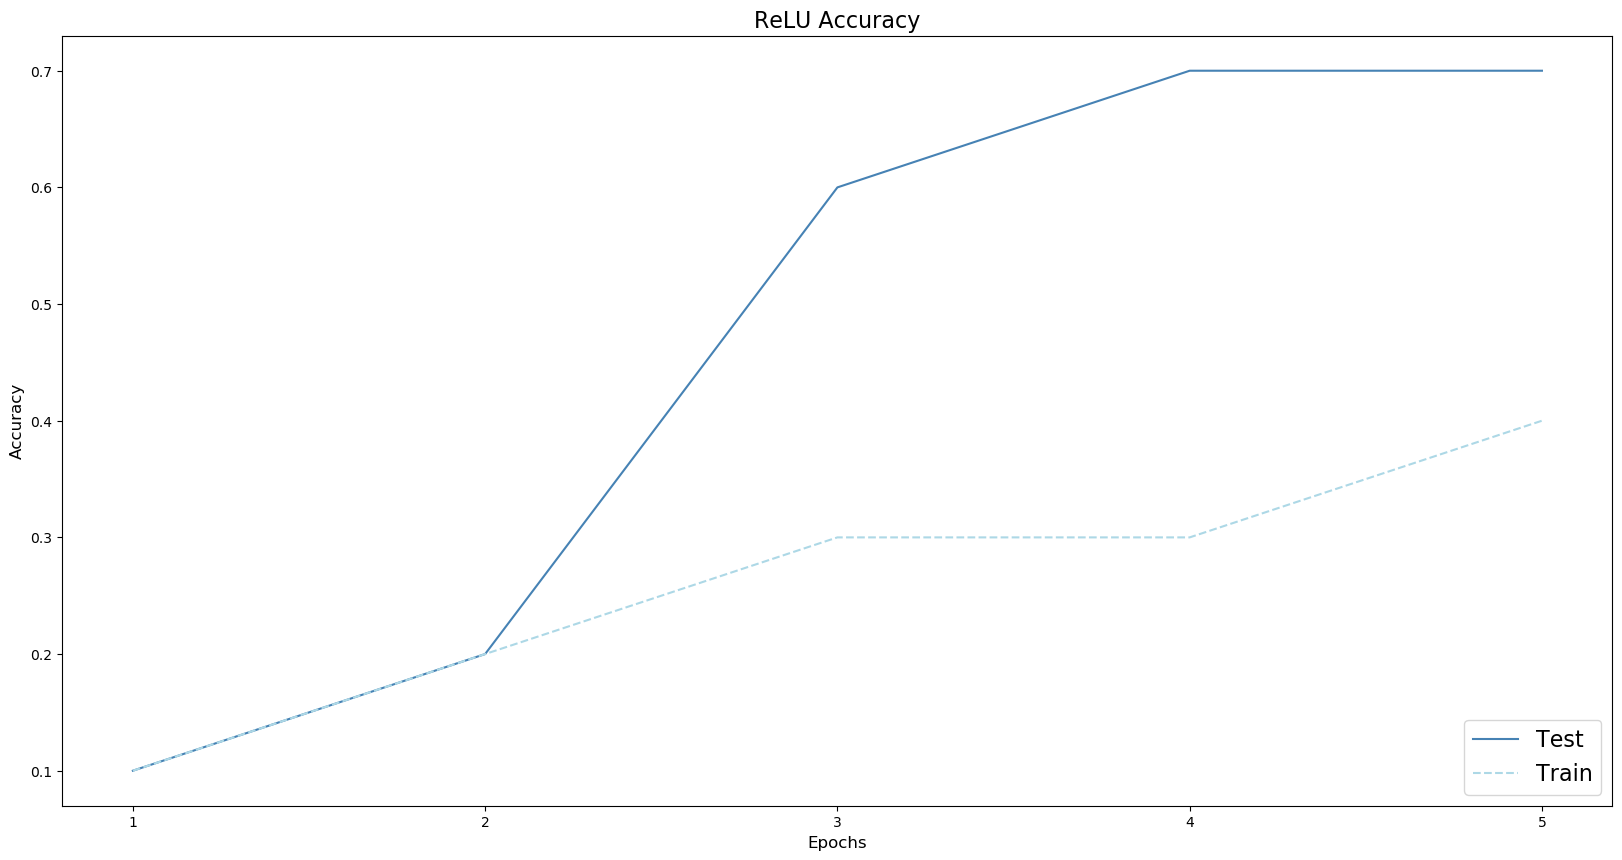

In [33]:
EPOCHS = 5 # get rid of test data
train_accuracies = [0.1, 0.2, 0.6, 0.7, 0.7]
test_accuracies = [0.1, 0.2, 0.3, 0.3, 0.4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs = [i for i in range(1,EPOCHS+1)]
ax.plot(epochs, train_accuracies, color="steelblue", label='Test')
ax.plot(epochs, test_accuracies, color="lightblue", ls='dashed', label='Train')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("ReLU Accuracy", fontsize=16)
plt.show()

In [37]:
class CustomNeuralNetwork_2(nn.Module):
    def __init__(self, activation):
        super().__init__()
        
        self.LeNet = nn.Sequential(     
            # convolutional layers            
            nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
              nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),    # CONVOLUTION 
              nn.BatchNorm2d(6),
              #nn.ReLU(),
              activation,
              nn.MaxPool2d(kernel_size=2, stride=2)),                 # POOLING
            nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
              nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),   # CONVOLUTION 
              nn.BatchNorm2d(16),
              #nn.ReLU(),
              activation,
              nn.MaxPool2d(kernel_size=2, stride=2)),                 # POOLING
            # fully connected layers
            nn.Flatten(),
            nn.Linear(16 * 125 * 125, 400),                            # THIRD LAYER: LINEAR YEAR, HIDDEN LAYER 2
            #nn.ReLU(),
            activation,                                                # HIDDEN LAYER's ACTIVATION FUNCION
            nn.Linear(400, 10)                                        # OUTPUT LAYER
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out

In [41]:
model = CustomNeuralNetwork_2(nn.Sigmoid())

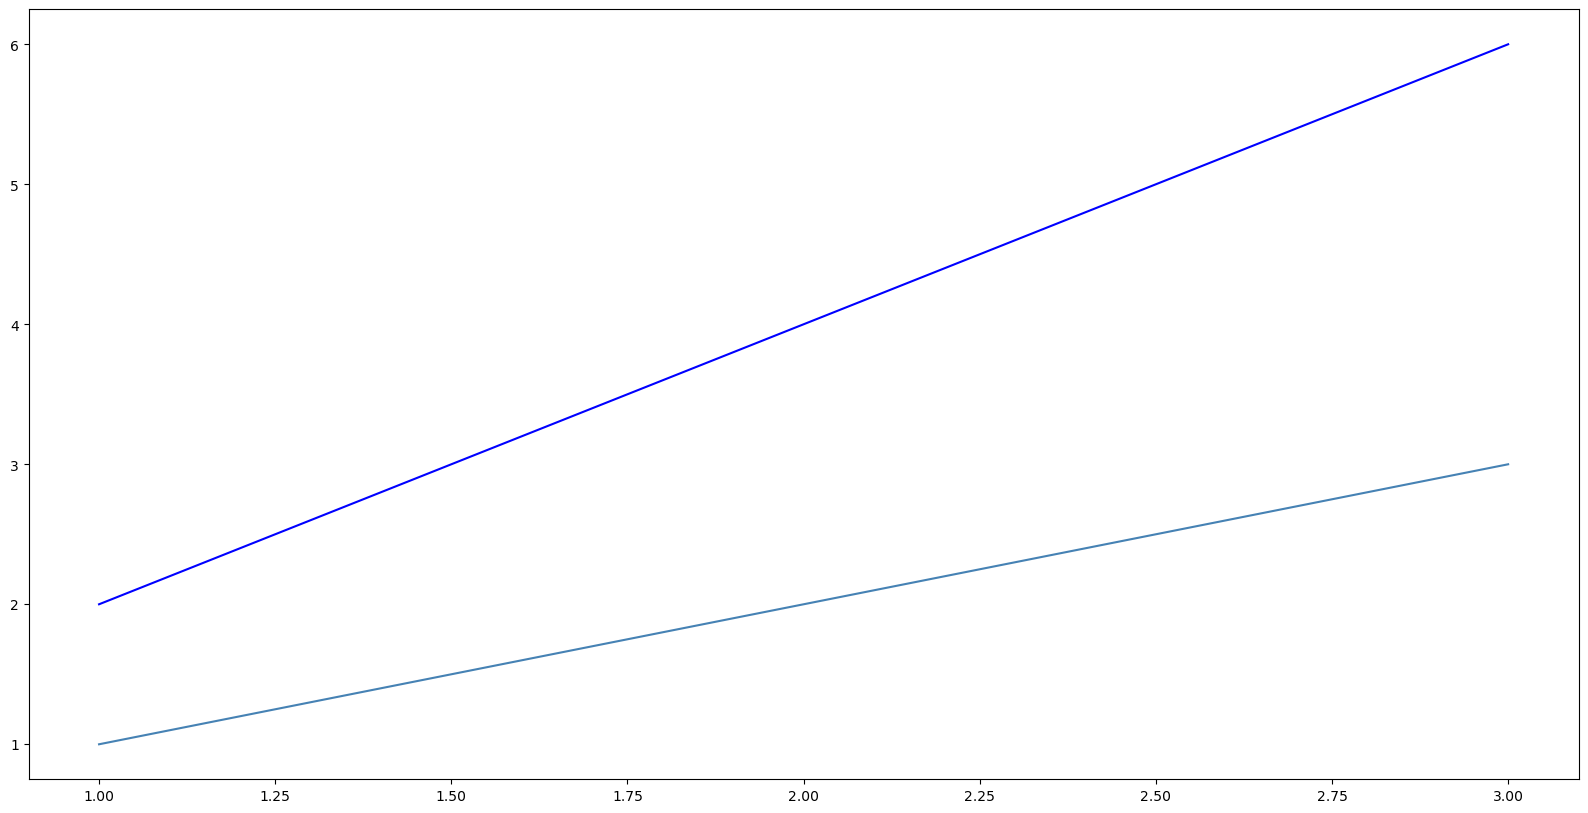

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
x = np.array([1, 2, 3])
colors = ["steelblue", "blue"]

for i, val in enumerate([1, 2]):
    y = x*val
    ax.plot(x, y, color= colors[i], label=val)


plt.show()

/home/lisettesolis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lisettesolis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


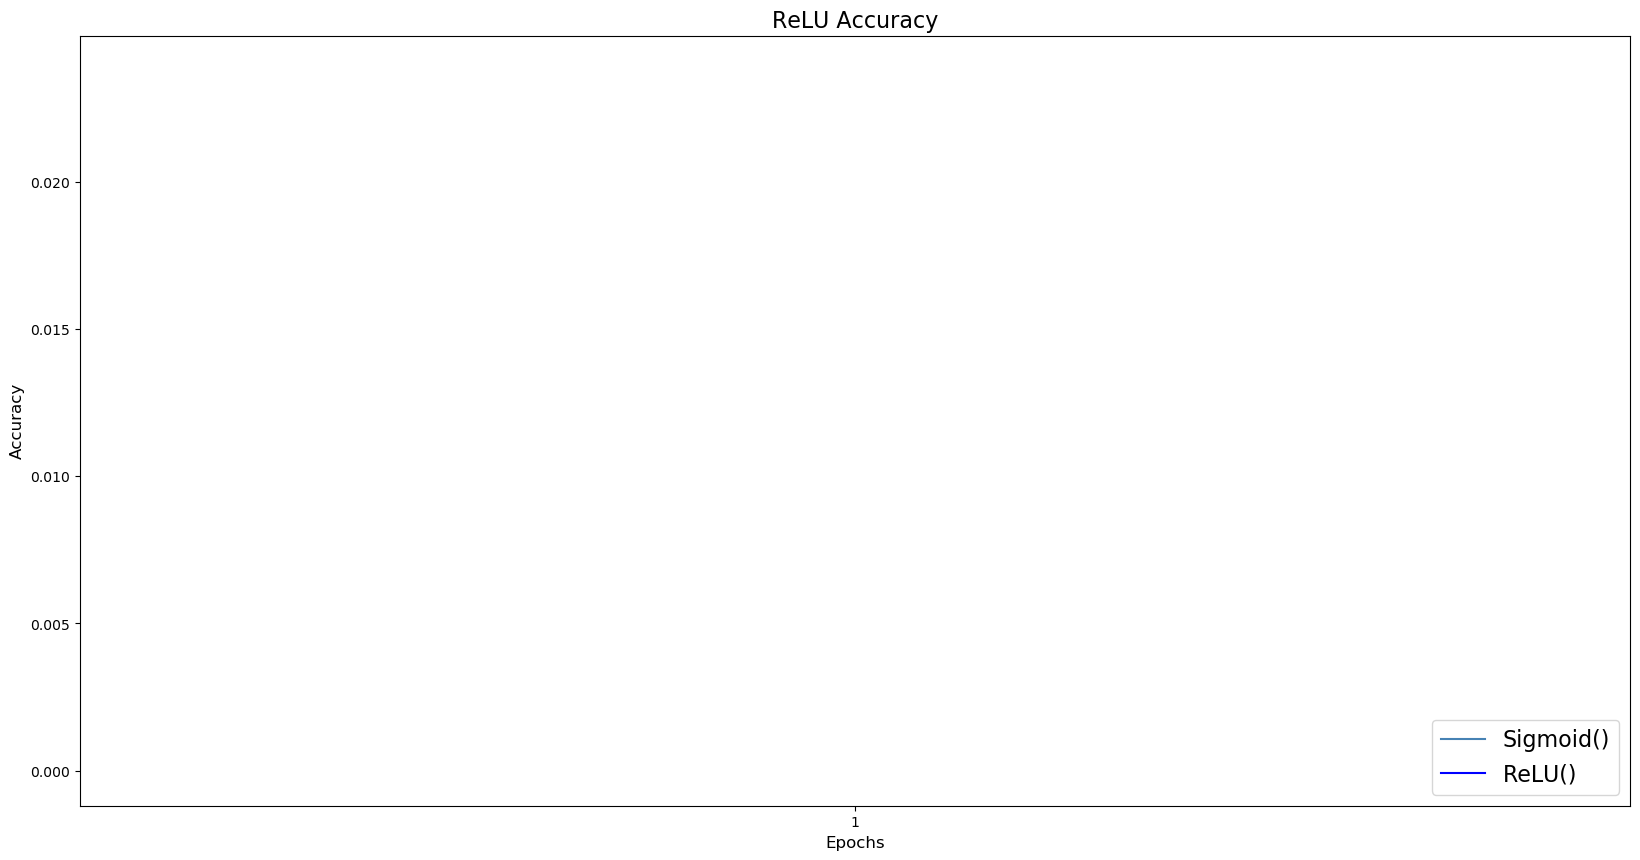

In [55]:
activations = [nn.Sigmoid(), nn.ReLU()]
colors = ["steelblue", "blue"]

#create plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs = [i for i in range(1,EPOCHS+1)]

for j, activation in enumerate(activations): 
    model = CustomNeuralNetwork_2(activation)
    
    # 4: Train and validate the network
    EPOCHS = 1
    train_losses = []
    train_accuracies = []
    for _ in range(EPOCHS):
        # TRAIN
        model.train()  # Make sure gradient tracking is on, and do a pass over the data
        running_loss = 0.0
        y_true = np.array([])
        y_predict = np.array([])
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward pass
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            loss = criterion(outputs, labels_tensor)  # calculate loss
            loss.backward()  # backward pass
            optimizer.step()  # update weights

            # keep track of the loss
            running_loss += loss.item()
            ypred_batch = np.argmax(outputs.detach().numpy(), axis=1)
            ytrue_batch = labels_tensor.numpy()
            y_predict = np.concatenate([y_predict, ypred_batch], axis=0)
            y_true = np.concatenate([y_true, ytrue_batch], axis=0)

        recall = recall_score(y_true, y_predict, average='weighted') # lisette changed average from binary because throwing an error 
        
        # avg_train_acc = total_correct/total_predicted  # calculate average accuracy metric
        avg_train_acc = recall
        avg_train_loss = running_loss / (i + 1)
         train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc) 
        # add line to plot for activation    
        ax.plot(epochs, train_accuracies, color=colors[j], label=activation)

#format plot
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("ReLU Accuracy", fontsize=16)
plt.show()